# Analysis of the Highest Grossing Films in the U.S. From 1999 - 2018
## By Shriya Sharma 

### INTRODUCTION
Internet Movie Database (IMDb) is an online database with information on films, television shows, video games, and online streaming content. In particular, the website contains a wide range of data on films, including titles, genres, runtimes, critic ratings, etc.  In this project, we will use the vast amount of information available on IMDb to analyze data on the highest grossing films in the United States between the years 1999 and 2018, and uncover some interesting trends and insights on the past two decades of film.

### REQUIRED LIBRARIES 
For this project, you will need the following libraries:
- requests
- beautiful soup 4
- regex 
- pandas
- matplotlib - pyplot
- scikit-learn
    - model_selection
    - linear_model
    - metrics
 
### DATA COLLECTION AND PROCESSING
In this stage of the data life cycle, we will focus on collecting data from IMDb and "fixing" it so that we can read and perform analysis on it.  

First, let's take a look at IMDb...

On IMDb, it is possible to filter searches and find all the movies released in a single year.  For instance, all the movies released in 2018 are available under the following URL:

https://www.imdb.com/search/title/?year=2018&title_type=feature&

We can reorganize this list of films by sorting it based on their U.S. Box Office performance in descending order.  This organization of information is available under the following URL (note: we will be using this URL format while scraping data later on!):

https://www.imdb.com/search/title/?title_type=feature&year=2018-01-01,2018-12-31&sort=boxoffice_gross_us,desc

Looking closely at the URL structure, we find one particular parameter of interest: the year.
It appears in the URL as follows: 

*year=2018-01-01,2018-12-31*

If we change this parameter to say, "year=1999-01-01,1999-12-31", in the above URL, we will be directed to a page with the top grossing films (in descending order) in the U.S. in 1999.  In fact, we can use this method to find the films released in virtually any year (as long as IMDb has information for that particular year).  Please note, that the above URL takes us to a page with the first fifty (50) films listed - in order to access the remainder of the list, you must go to the next page(s).  However, since we are only focusing on the top 50 grossing films from each year, we do not need to worry about this.  

Looking at the all the data available on a single page, we will select the following data for each of the films in question for our analysis:
- Title
- Release year
- Runtime (in minutes)
- Public rating (a score out of 10)
    - This will be based on the IMDb rating - the average rating given by users of IMDb
- Critics rating (a score out of 100)
    - This will be based on the Metacritic rating - an aggregation of ratings by critics 
- Number of public votes
- MPAA Rating (G, PG, PG13, or R)
- US Box Office Performance (in millions)

With all this information in mind, let us begin the process of web scraping.  

Using a for-loop, we will iterate through all the years in question and obtain the necessary information from the corresponding webpage for each year. We do this by first forming the URL we need to access based on the current year iteration.  Then, using get(), we request the content of the webpage from the server and store this information in a variable called 'response'.  We then use Beautiful Soup to parse the page content using html.parser.  

Looking at the HTML code, we find that information for each of the 50 films listed is located in corresponding div containers under the name 'lister-item mode-advanced'. 
With this in mind, we use the findAll() function to store each of these 50 containers in a variable called 'containers'.  Using a for-loop, we will iterate through the containers and extract the necessary data for each movie.  This step requires looking at the HTML code within a single 'lister-item mode-advanced' div container to see what format it follows and formulate a way to access the desired data.  In the process of doing so, we also make some "fixes."  For instance, in some cases the year format of the film can be a bit funky and include letters, parentheses, etc. so we eliminate this issue by using regex to only store numbers.  Additionally, each container lists three genres the film falls under, but for the sake of simplicity, we use only one genre: the first listed genre, which is the most accurate of the three.   


In [669]:
from requests import get
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

titles = []
years = []
genres = []
runtimes = []
public_ratings = []
critic_ratings = []
num_votes_list = []
mpaa_ratings = []
box_office = []

for i in range(1999,2019):
    # Form URL based on year
    url = "https://www.imdb.com/search/title/?title_type=feature&year="+str(i)+"-01-01,"+str(i)+"-12-31&sort=boxoffice_gross_us,desc"
    response = get(url)
    
    # Use BeautifulSoup to parse page content 
    soup = BeautifulSoup(response.text, 'html.parser')
    containers = soup.find_all('div', class_ = 'lister-item mode-advanced')
    
    for curr in containers:
        # Exclude any films without a Metacritic score from our dataset 
        if curr.find('div', class_ = 'inline-block ratings-metascore') is not None:
            # Extract film information and store in corresponding list:
            # TITLE
            title = curr.h3.a.text
            titles.append(title)
            # YEAR
            year = curr.h3.find('span', class_ = 'lister-item-year text-muted unbold').text
            year = re.sub("[^0-9]", "", year)
            years.append(int(year))
            # GENRE
            genre = curr.p.find('span', class_ = 'genre').text
            genre = genre[1:]
            # For simplicity, we will only use the first listed genre (which is the most accurate choice)
            genre_list = genre.split(',')
            genre = genre_list[0].strip()
            genres.append(genre)
            # RUNTIME
            runtime = curr.p.find('span', class_ = 'runtime').text
            runtime = int(runtime [:-4])
            runtimes.append(runtime)
            # PUBLIC (IMDB) RATING
            public_rating = float(curr.strong.text)
            public_ratings.append(public_rating)
            # CRITIC (METACRITIC) RATING
            critic_rating = int(curr.find('div', class_ = 'inline-block ratings-metascore').span.text)
            critic_ratings.append(critic_rating)
            # NUMBER OF PUBLIC VOTES
            num_votes = int(curr.find('span', attrs = {'name':'nv'})['data-value'])
            num_votes_list.append(num_votes)
            # MPAA CERTIFCATION
            mpaa = curr.p.find('span', class_ = 'certificate').text
            mpaa_ratings.append(mpaa)
            # BOX OFFICE (IN MILLIONS)
            votes_gross = curr.findAll('span', attrs = {'name':'nv'})
            gross = votes_gross[1]['data-value']
            gross = gross.replace(',', '')
            # Gross in millions!
            gross = round(int(gross)/1000000,1)
            box_office.append(gross)

Now that we have all the necessary information stored in lists, we can create a DataFrame to store all the data.

In [670]:
df = pd.DataFrame({'title': titles, 
                  'year': years,
                  'genre': genres,
                  'runtime': runtimes, 
                  'imdb_rating': public_ratings,
                  'metacritic_rating': critic_ratings,
                  'num_votes': num_votes_list,
                  'mpaa_rating': mpaa_ratings,
                  'gross_millions': box_office})

df

,title,year,genre,runtime,imdb_rating,metacritic_rating,num_votes,mpaa_rating,gross_millions
0,Star Wars: Episode I - The Phantom Menace,1999,Action,136,6.5,51,673649,PG,474.5
1,The Sixth Sense,1999,Drama,107,8.1,64,864180,PG-13,293.5
2,Toy Story 2,1999,Animation,92,7.9,88,492851,G,245.9
3,Austin Powers: The Spy Who Shagged Me,1999,Action,95,6.6,59,207732,PG-13,206.0
4,The Matrix,1999,Action,136,8.7,73,1560902,R,171.5
5,Tarzan,1999,Animation,88,7.3,79,189038,G,171.1
6,Big Daddy,1999,Comedy,93,6.4,41,189113,PG-13,163.5
7,The Mummy,1999,Action,124,7.0,48,373425,PG-13,155.2
8,Runaway Bride,1999,Comedy,116,5.5,39,88873,PG,152.3
9,The Blair Witch Project,1999,Horror,81,6.5,81,221222,R,140.5


We call the info() function to ensure that we have all the data columns we want and that each column corresponds to the correct datatype.

In [671]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
title                1000 non-null object
year                 1000 non-null int64
genre                1000 non-null object
runtime              1000 non-null int64
imdb_rating          1000 non-null float64
metacritic_rating    1000 non-null int64
num_votes            1000 non-null int64
mpaa_rating          1000 non-null object
gross_millions       1000 non-null float64
dtypes: float64(2), int64(4), object(3)
memory usage: 70.4+ KB


We call unique() function on df.genre to ensure that all the genres in the table are acceptable and there are no repeats or strange cases (e.g. having "action" and "Action" as two separate genres)

In [672]:
df.genre.unique()

array(['Action', 'Drama', 'Animation', 'Comedy', 'Horror', 'Adventure',
       'Crime', 'Fantasy', 'Biography', 'Mystery', 'Sci-Fi', 'Family'],
      dtype=object)

We call the unique() function on df.mpaa_rating and find that some films have been rated as 'Approved'.  This term, however, is not consistent with MPAA rating guidelines, which delineates the following official rating terms: 
- G : General Audiences 
- PG : Parental Guidance Suggested
- PG-13 : Parents Strongly Cautioned 
- R : Restricted
- NC-17 : Adults Only

In [673]:
df.mpaa_rating.unique()

array(['PG', 'PG-13', 'G', 'R', 'Approved'], dtype=object)

To eliminate this issue, we remove any instances in the DataFrame where the MPAA Rating is listed as 'Approved'. 
We also remove any instances from the DataFrame where the IMDb Rating is not between 0 and 10 and where the Metacrtic Rating is not between 0 and 100 and where the year is not between 1999-2018. 

In [674]:
df = df[df.mpaa_rating != 'Approved']
df = df[(df.imdb_rating >= 0) & (df.imdb_rating <= 10)]
df = df[(df.metacritic_rating >= 0) & (df.imdb_rating <= 100)]
df = df[(df.year >= 1999) & (df.year <= 2018)]

We also remove any instances that contain null values for any of the attributes in question.  

In [675]:
df = df[pd.notnull(df['title'])]
df = df[pd.notnull(df['year'])]
df = df[pd.notnull(df['genre'])]
df = df[pd.notnull(df['runtime'])]
df = df[pd.notnull(df['imdb_rating'])]
df = df[pd.notnull(df['num_votes'])]
df = df[pd.notnull(df['mpaa_rating'])]
df = df[pd.notnull(df['gross_millions'])]

Here is a look at our final DataFrame that we will be using in the following stages of this project:

In [676]:
df

,title,year,genre,runtime,imdb_rating,metacritic_rating,num_votes,mpaa_rating,gross_millions
0,Star Wars: Episode I - The Phantom Menace,1999,Action,136,6.5,51,673649,PG,474.5
1,The Sixth Sense,1999,Drama,107,8.1,64,864180,PG-13,293.5
2,Toy Story 2,1999,Animation,92,7.9,88,492851,G,245.9
3,Austin Powers: The Spy Who Shagged Me,1999,Action,95,6.6,59,207732,PG-13,206.0
4,The Matrix,1999,Action,136,8.7,73,1560902,R,171.5
5,Tarzan,1999,Animation,88,7.3,79,189038,G,171.1
6,Big Daddy,1999,Comedy,93,6.4,41,189113,PG-13,163.5
7,The Mummy,1999,Action,124,7.0,48,373425,PG-13,155.2
8,Runaway Bride,1999,Comedy,116,5.5,39,88873,PG,152.3
9,The Blair Witch Project,1999,Horror,81,6.5,81,221222,R,140.5


### EXPLORATORY ANALYSIS AND DATA VISUALIZATION

In this stage of the data life cycle, we are focusing on visualizing data and finding potential trends. 

In the following "Critics vs. Public Ratings" plot, we see that in general, public ratings of films are fairly consistent with critics ratings.  While the public seems to give generally favorable ratings (5 and above), critics ratings generally seem to be a bit harsher, with a lot of ~5/10 films (based on public ratings) falling in the 30/100 - 40/100 range for critics ratings.   

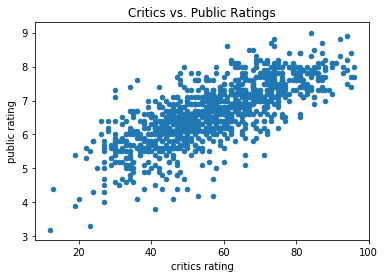

In [677]:
# Critic rating vs. Public rating 
df.plot(x='metacritic_rating',y='imdb_rating',kind='scatter')
plt.xlabel('critics rating')
plt.ylabel('public rating')
plt.title('Critics vs. Public Ratings')
plt.show()

In the following "Runtime vs. Critics Ratings" plot, we find that with films around 80-120 minutes, there is more variation in critics ratings and there is a higher concentration of critics ratings.  As runtime increases, there is a trend towards higher critics ratings.  

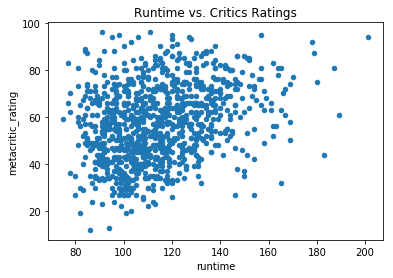

In [678]:
# Runtime vs. Critics Rating
df.plot(x='runtime',y='metacritic_rating',kind='scatter')
plt.xlabel('runtime')
plt.ylabel('metacritic_rating')
plt.title('Runtime vs. Critics Ratings')
plt.show()

In the following "Runtime vs. Public Ratings" plot, we find that public ratings are most concentrated in the 80-120 minute range.  The plot suggests that as runtime increases, public rating also increases.

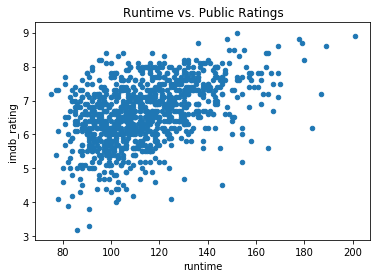

In [679]:
# Runtime vs. Public Rating
df.plot(x='runtime',y='imdb_rating',kind='scatter')
plt.xlabel('runtime')
plt.ylabel('imdb_rating')
plt.title('Runtime vs. Public Ratings')
plt.show()

In the following "Public Ratings vs. Box Office" plot, we see that movies that are highly rated by the public generally tend do well at the box office.

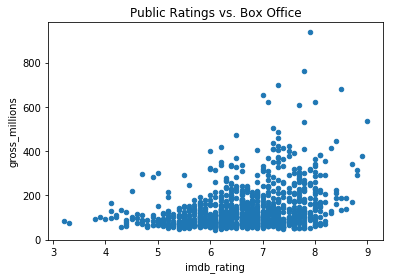

In [680]:
# Public Ratings vs. Box Office
df.plot(x='imdb_rating',y='gross_millions',kind='scatter')
plt.xlabel('imdb_rating')
plt.ylabel('gross_millions')
plt.title('Public Ratings vs. Box Office')
plt.show()

In the following "Critics Ratings vs. Box Office" plot, we see that movies that are highly rated by the critics generally tend do well at the box office.  Critics, however, seem more demanding and harsher on films than the public, as a lot of films that perform well at the box seem to have lower critics ratings.   

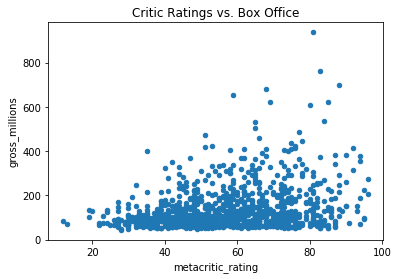

In [681]:
# Critic Ratings vs. Box Office
df.plot(x='metacritic_rating',y='gross_millions',kind='scatter')
plt.xlabel('metacritic_rating')
plt.ylabel('gross_millions')
plt.title('Critic Ratings vs. Box Office')
plt.show()

In the following "Runtime vs. Box Office" plot, we see that films around 80-150 minutes generally tend to bring in the most money.  Films longer than 140 minutes seem to bring in less revenue.  From a business standpoint, it seems more profitable to make a film between 80-150 minutes.

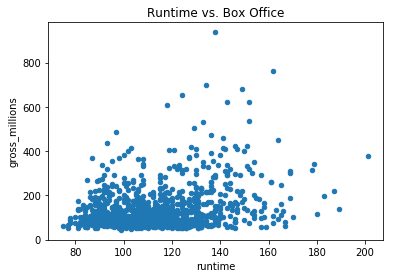

In [682]:
# Runtime vs. Box Office 
df.plot(x='runtime',y='gross_millions',kind='scatter')
plt.xlabel('runtime')
plt.ylabel('gross_millions')
plt.title('Runtime vs. Box Office')
plt.show()

In the distribution plot below, public (IMDb) ratings seem to be most concentrated in the 6.25/10 - 8.25/10 range.  

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


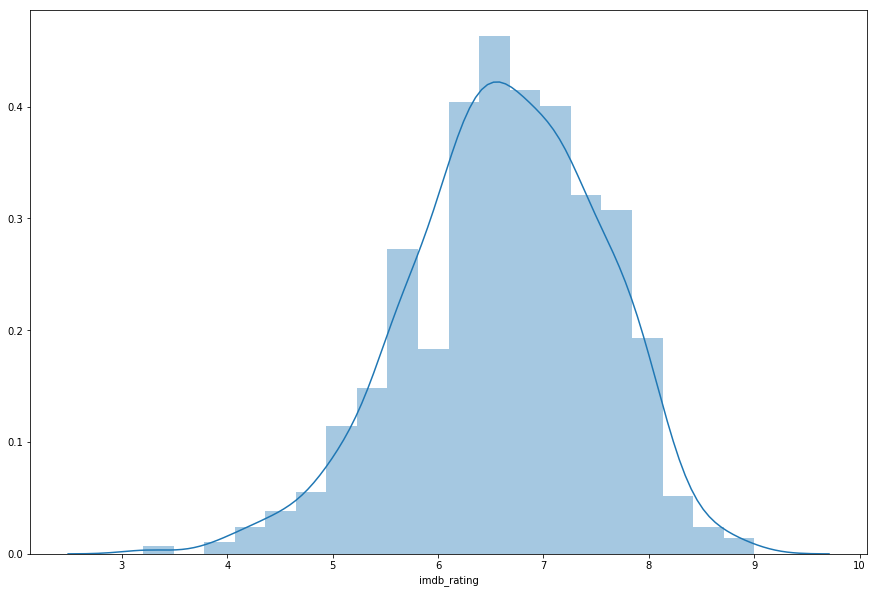

In [683]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df.imdb_rating, bins = 20)
plt.show()

In the distribution plot below, critics (Metacritic) ratings seem to be most concentrated in the 40/100 - 75/100 range, implying that critics tend to be harsher in their ratings than the public. 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


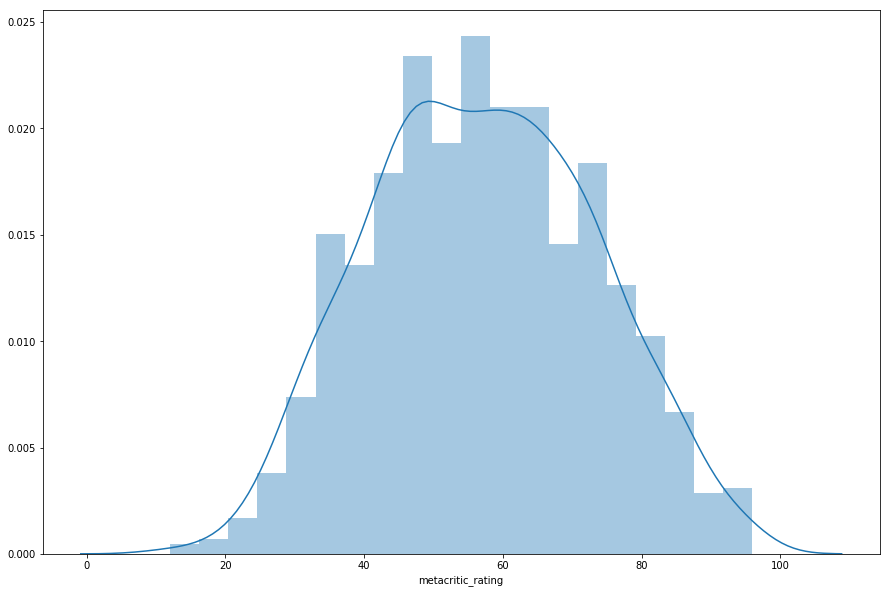

In [684]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df.metacritic_rating, bins = 20)
plt.show()

In the distribution plot below, top 50 film runtimes tend to fall in the 80-150 minute range.  

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


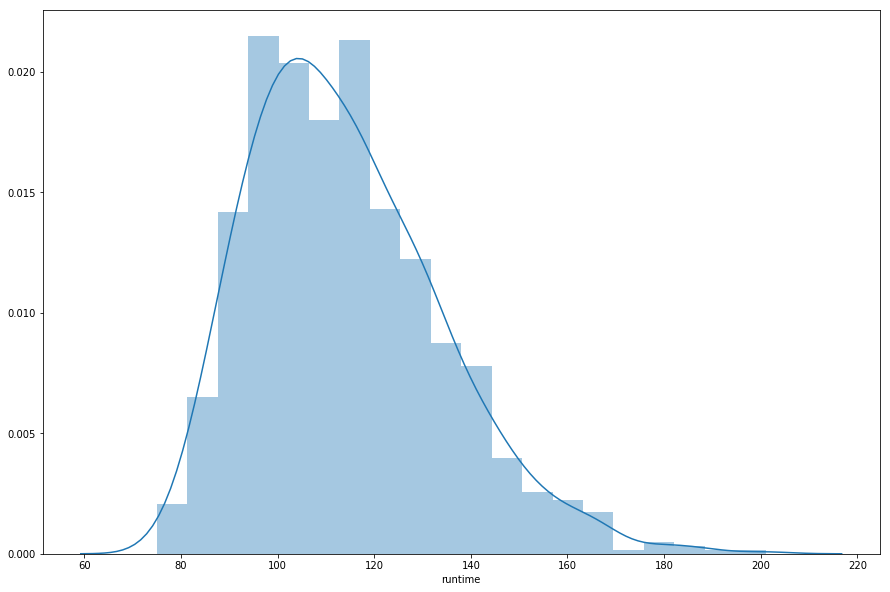

In [685]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df.runtime, bins = 20)
plt.show()

In the distribution plot below, we find that films tend to make under 200 million dollars in the U.S., with most making around 100 million dollars more or less.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


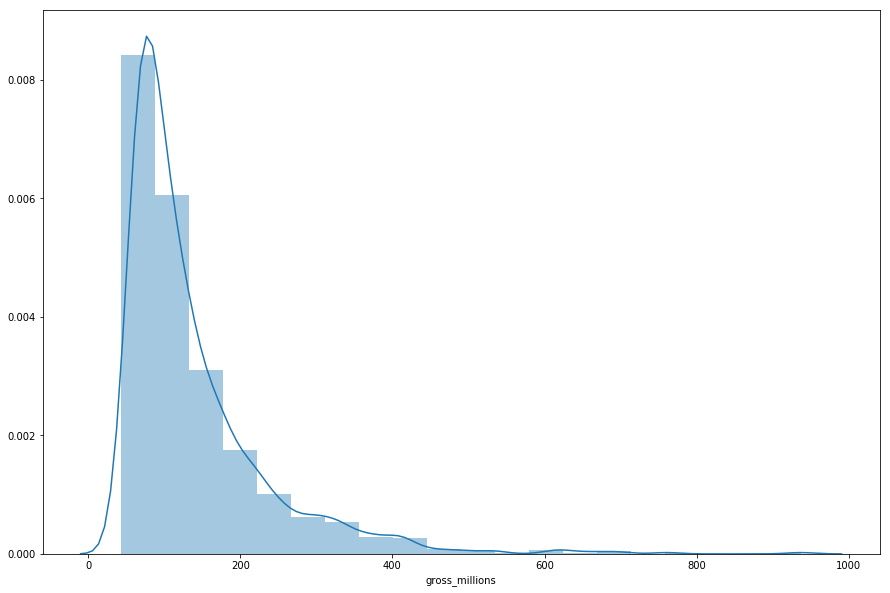

In [686]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(df.gross_millions, bins = 20)
plt.show()

In the bar graph below, we see that action films far outnumbered other genres at the box office and that action is by far the most popular genre.  

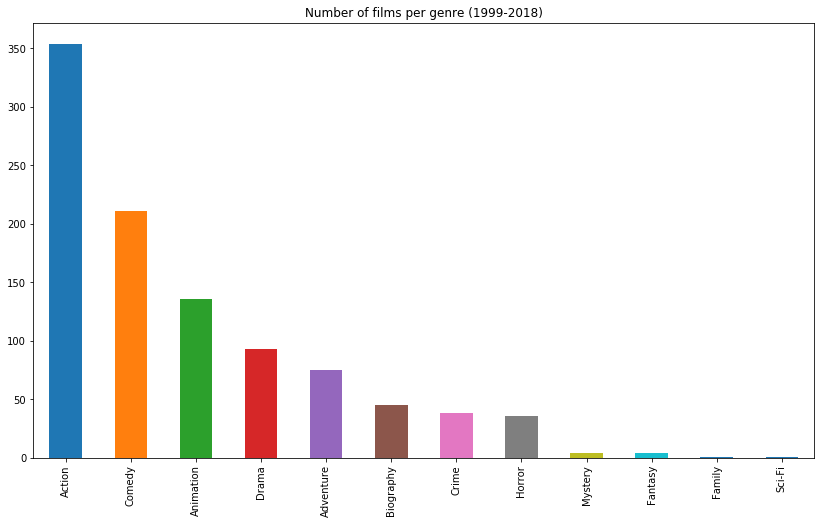

In [687]:
ax = df['genre'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of films per genre (1999-2018)")

We now create new subsets of the larger DataFrame that either contain films of a specific genre or MPAA rating.  For the sake of simplicty, we are only making DataFrames for the top 5 genres which are (as shown in the above bar graph):
1. Action
2. Comedy 
3. Animation
4. Drama 
5. Adventure

In [688]:
# Genre-specific DataFrames
df_action = df.loc[(df.genre == 'Action')]
df_comedy = df.loc[(df.genre == 'Comedy')]
df_animation = df.loc[(df.genre == 'Animation')]
df_drama = df.loc[(df.genre == 'Drama')]
df_adventure = df.loc[(df.genre == 'Adventure')]

In [689]:
# MPAA rating-specific DataFrames
df_g = df.loc[(df.mpaa_rating == 'G')]
df_pg = df.loc[(df.mpaa_rating == 'PG')]
df_pg13 = df.loc[(df.mpaa_rating == 'PG-13')]
df_r = df.loc[(df.mpaa_rating == 'R')]

In the 'Critics vs Public Rating by Genre' plot below, we find that critics and public ratings are generally in agreement with each other, especially for Animation and Biography films, with Biography films being particularly highly rated among both groups.  When it comes to films where there is more of a difference between public and critics opinion, these films tend to be either Action or Comedy. 

In the 'Critics vs Public Rating by MPAA Rating' plot, we find that most of the lower rated films tend to be PG-13 and that Rated R films appear to be more concentrated on the higher end of ratings. 

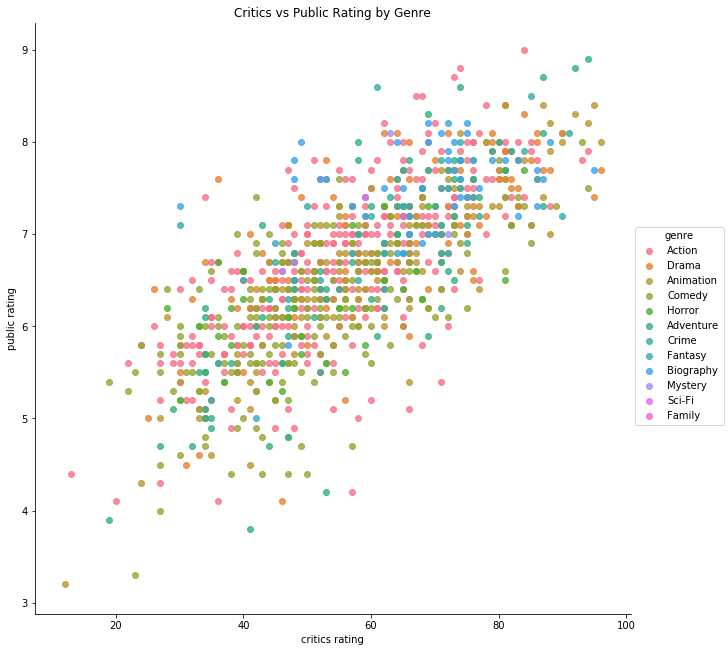

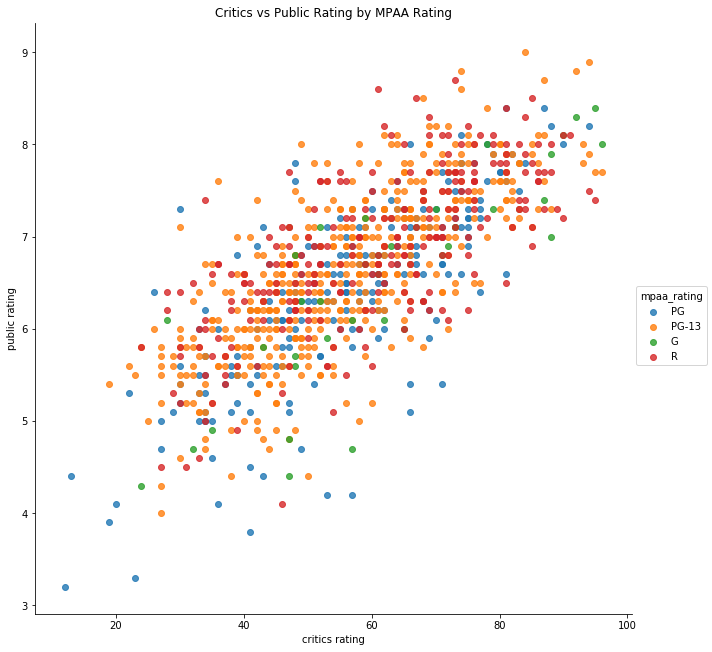

In [690]:
fig = sns.lmplot(data=df, x='metacritic_rating', y='imdb_rating', fit_reg=False, hue='genre', size=9, aspect=1)
fig.set(xlabel='critics rating', ylabel='public rating', title = 'Critics vs Public Rating by Genre')
plt.show()

fig = sns.lmplot(data=df, x='metacritic_rating', y='imdb_rating', fit_reg=False, hue='mpaa_rating', size=9, aspect=1)
fig.set(xlabel='critics rating', ylabel='public rating', title = 'Critics vs Public Rating by MPAA Rating')
plt.show()

In the 'Critics vs Box Office by Genre' plot, we see that the best performing films at the box office tend to be Action films and that many Action films, despite having relatively low critics rating, can still perform very well at the box office.  Biography films, while being generally highly rated by critics, tend to not bring nearly as much in revenue as Action films.  

In the 'Critics vs Box Office by MPAA Rating' plot, we see that many PG-13 films have done well at the box office in spite of critics ratings on the lower end.  Rated R films, despite a significant portion of them being highly rated, tend to make around 100 million dollars and rarely more than 200 million dollars.

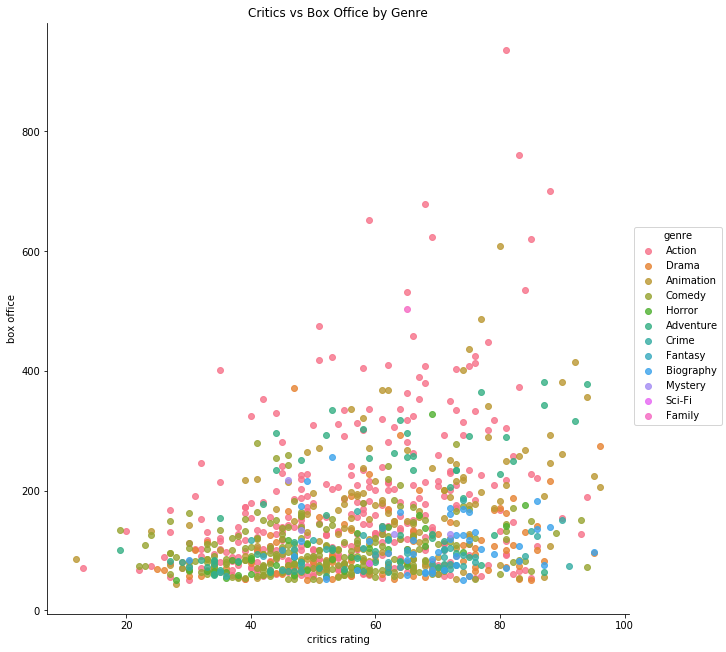

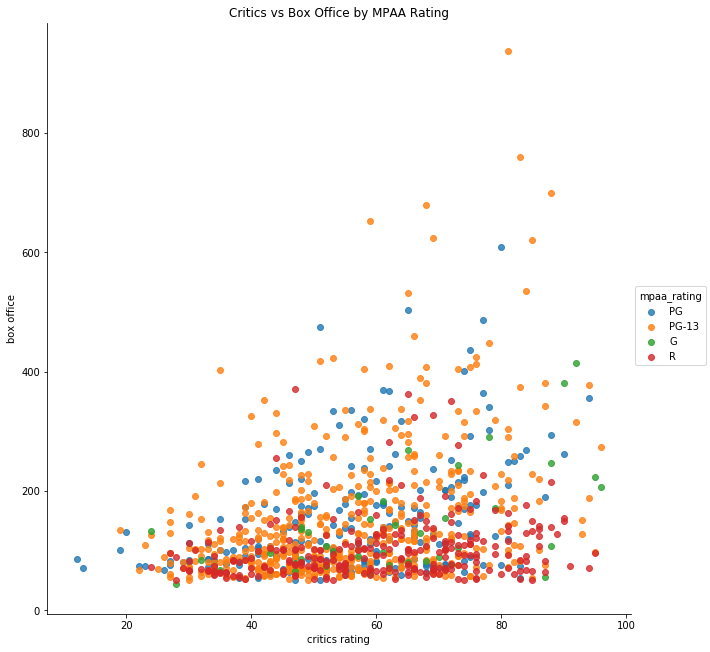

In [691]:
fig = sns.lmplot(data=df, x='metacritic_rating', y='gross_millions', fit_reg=False, hue='genre', size=9, aspect=1)
fig.set(xlabel='critics rating', ylabel='box office', title = 'Critics vs Box Office by Genre')
plt.show()

fig = sns.lmplot(data=df, x='metacritic_rating', y='gross_millions', fit_reg=False, hue='mpaa_rating', size=9, aspect=1)
fig.set(xlabel='critics rating', ylabel='box office', title = 'Critics vs Box Office by MPAA Rating')
plt.show()

In the 'Public Rating vs Box Office by Genre' plot, we see that Action films do the best at the box office among highly rated films.  Biography films tend to be highly rated, but generally do not make as much as Animation or Comedy films.  

In the 'Public Rating vs Box Office by MPAA Rating' plot, we see the best performing films in terms of box office and public ratings tend to be PG-13 or PG.

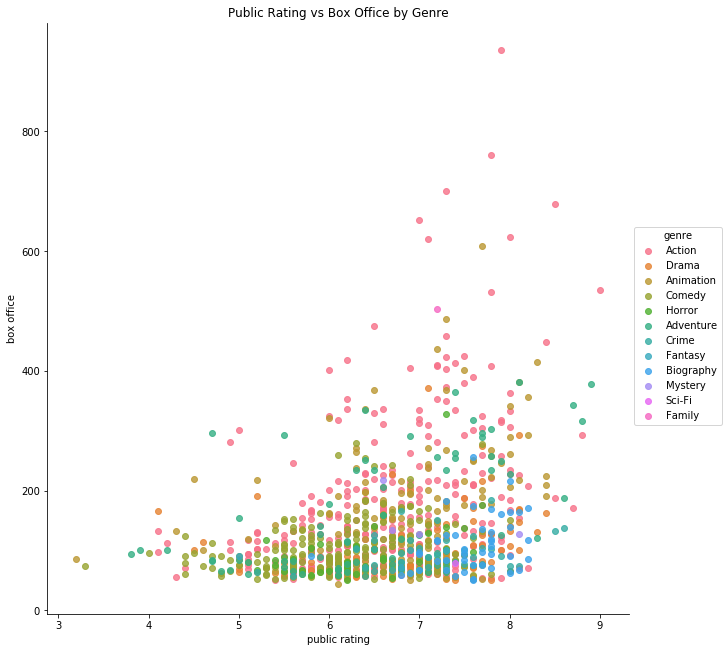

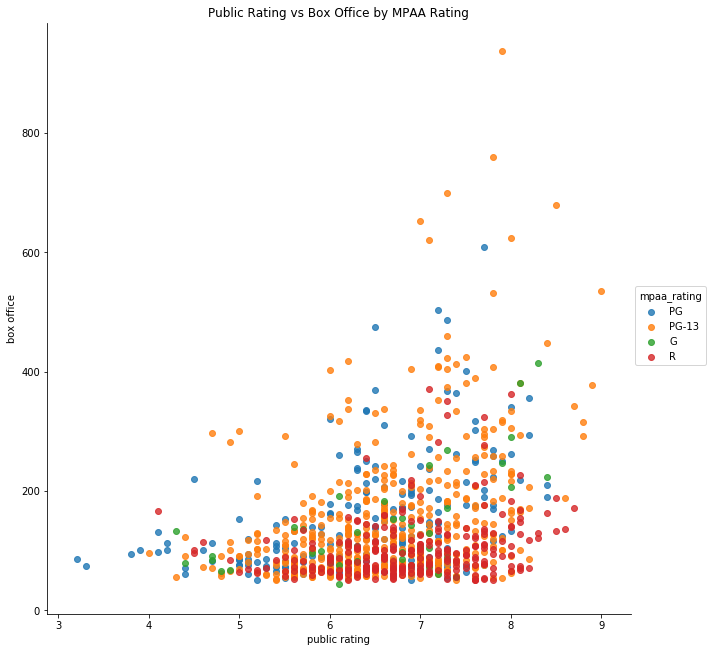

In [692]:
fig = sns.lmplot(data=df, x='imdb_rating', y='gross_millions', fit_reg=False, hue='genre', size=9, aspect=1)
fig.set(xlabel='public rating', ylabel='box office', title = 'Public Rating vs Box Office by Genre')
plt.show()

fig = sns.lmplot(data=df, x='imdb_rating', y='gross_millions', fit_reg=False, hue='mpaa_rating', size=9, aspect=1)
fig.set(xlabel='public rating', ylabel='box office', title = 'Public Rating vs Box Office by MPAA Rating')
plt.show()

In the 'Runtime vs Box Office by Genre' plot, we see that the longer films (120-150 minutes) that also perform well at the box office tend to be Action.  The shorter films (80-100 minutes) that also perform well at the box office tend to be Animation.  This could possibly be because many Animation films are geared towards children, who generally have shorter attention spans than older people.  

In the 'Runtime vs Box Office by MPAA Rating' plot, we see that longer films (120-150 minutes) that also perform well at the box office tend to be PG-13.  The shorter films (80-100 minutes) that also perform well at the box office tend to be PG.

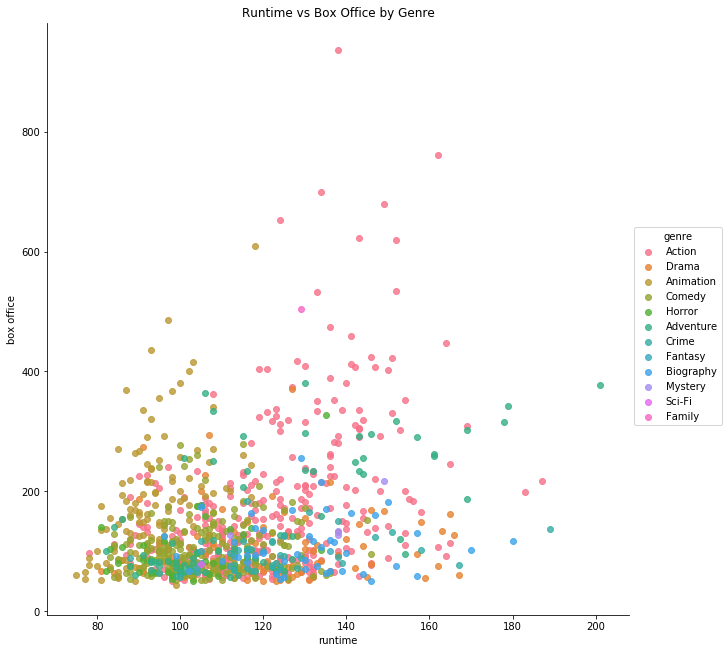

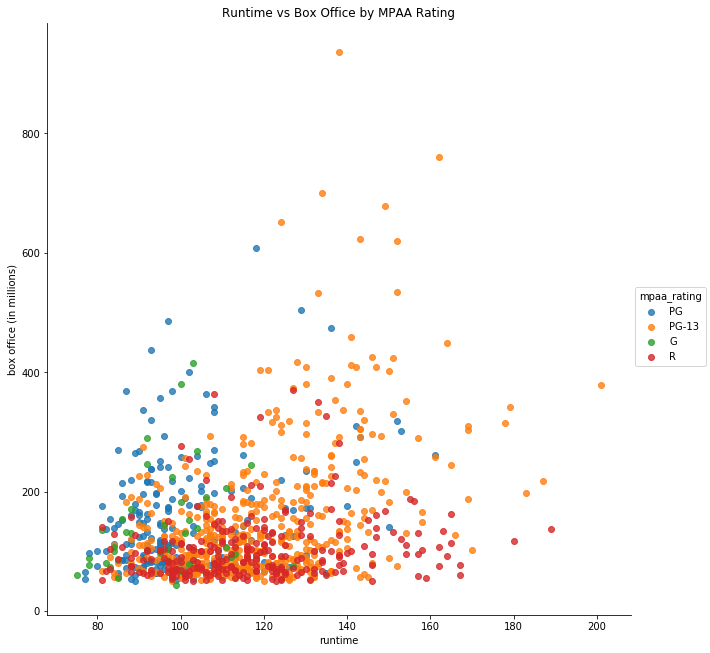

In [693]:
fig = sns.lmplot(data=df, x='runtime', y='gross_millions', fit_reg=False, hue='genre', size=9, aspect=1)
fig.set(xlabel='runtime', ylabel='box office', title = 'Runtime vs Box Office by Genre')
plt.show()

fig = sns.lmplot(data=df, x='runtime', y='gross_millions', fit_reg=False, hue='mpaa_rating', size=9, aspect=1)
fig.set(xlabel='runtime', ylabel='box office (in millions)', title = 'Runtime vs Box Office by MPAA Rating')
plt.show()

In the following set of bar graphs, we display the number of films of a particular genre in the Top 50 box office per year.  Recall that for the sake of simplicty, we will only be exploring the Top 5 genres.  In the following bar graphs, we observe the following trends: 
- The number of Action films per year has steadily increased, with 2014 being the biggest year for Action movies.  
- The number of Comedy films per year has steadily decreased over the years.
- The number of Animation films has generally increased over the years.
- The number of Drama films fluctuates quite a bit over the years.

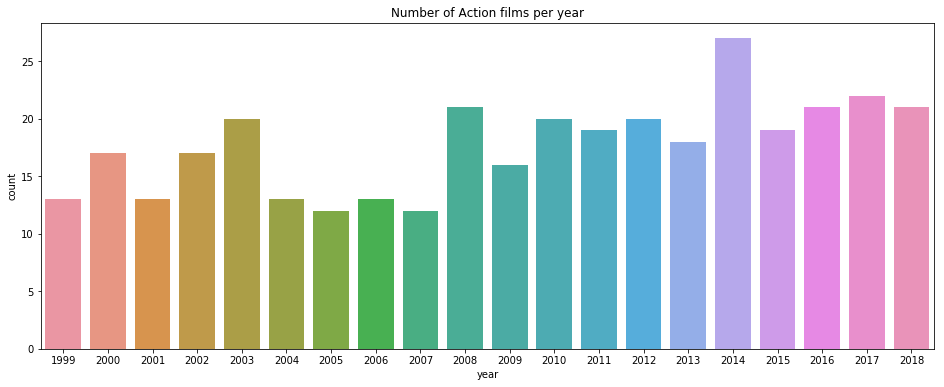

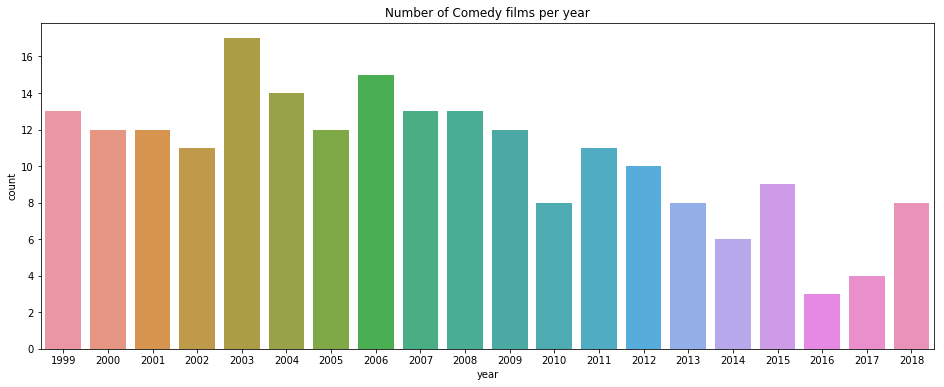

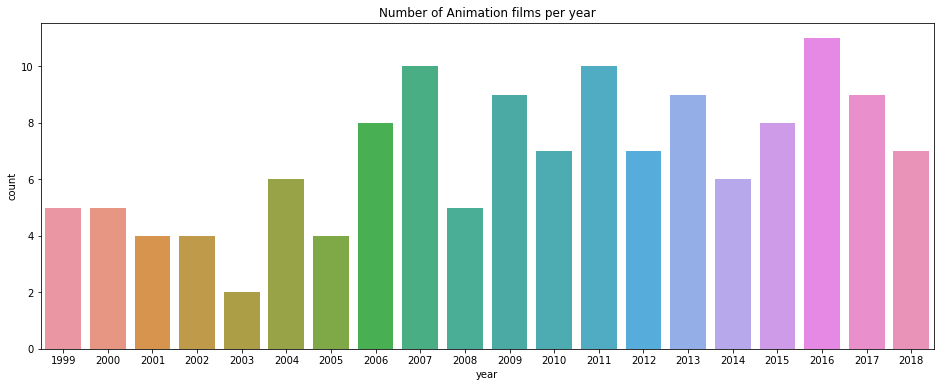

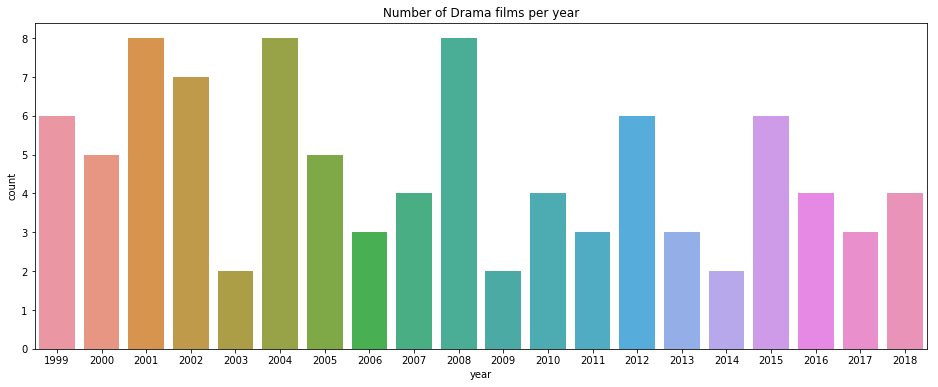

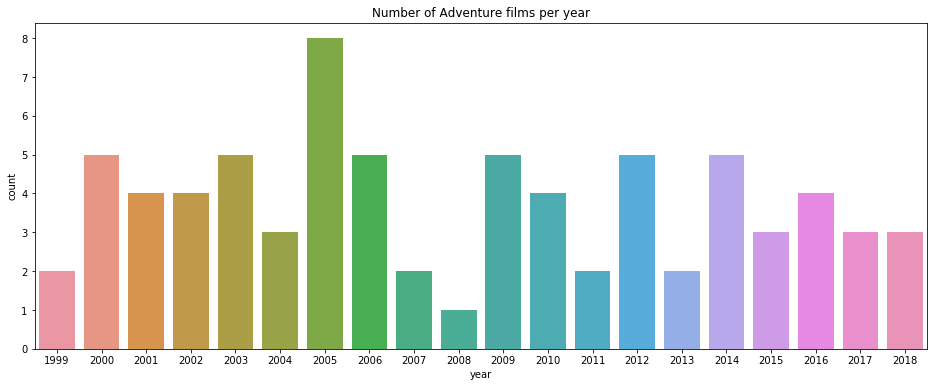

In [694]:
plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_action)
fig.set(xlabel='year', ylabel='count', title = 'Number of Action films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_comedy)
fig.set(xlabel='year', ylabel='count', title = 'Number of Comedy films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_animation)
fig.set(xlabel='year', ylabel='count', title = 'Number of Animation films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_drama)
fig.set(xlabel='year', ylabel='count', title = 'Number of Drama films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_adventure)
fig.set(xlabel='year', ylabel='count', title = 'Number of Adventure films per year')
plt.show()

In the following set of bar graphs, we display the number of films of a particular MPAA rating in the Top 50 box office per year.  In the following bar graphs, we observe the following trends: 
- 1999 and 2000 were big years for G rated films, but since then, the number of G rated films films have declined, with 2011 being the most recent year with numbers comparable to 1999/2000.
- The number of PG films has increased steadily over the years.
- The number of PG-13 and Rated R films have stayed relatively the same. 

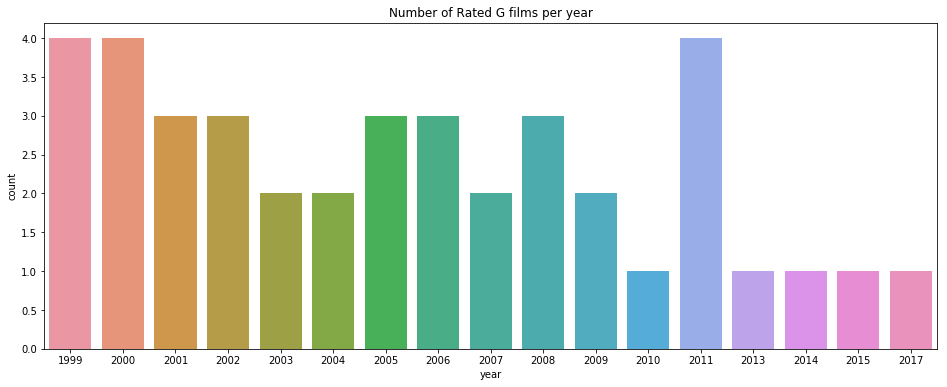

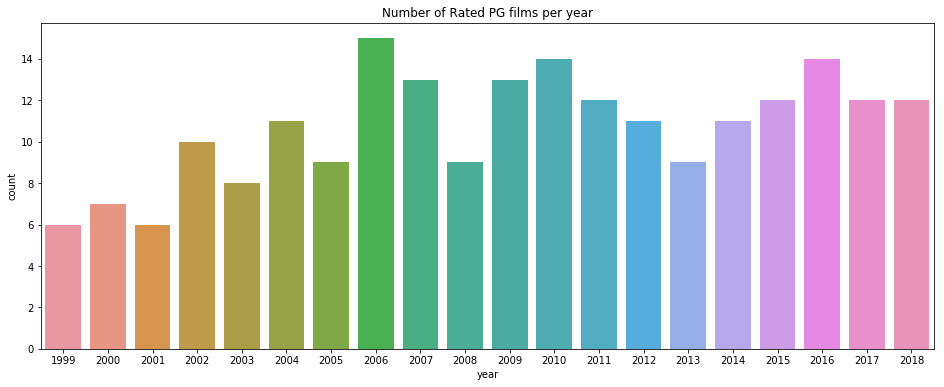

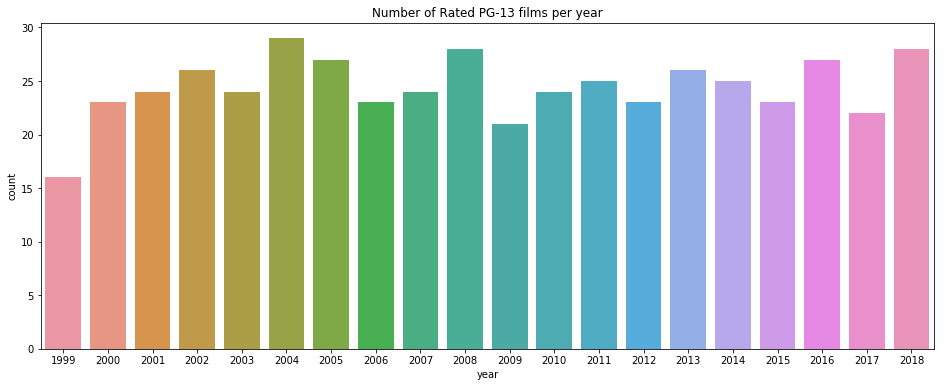

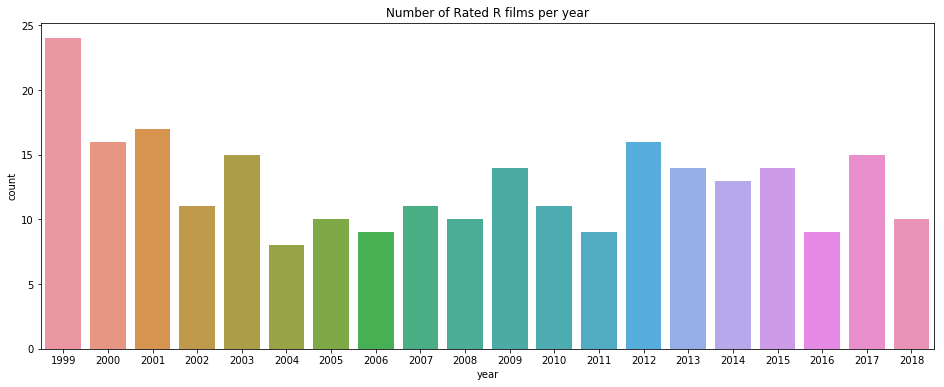

In [695]:
plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_g)
fig.set(xlabel='year', ylabel='count', title = 'Number of Rated G films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_pg)
fig.set(xlabel='year', ylabel='count', title = 'Number of Rated PG films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_pg13)
fig.set(xlabel='year', ylabel='count', title = 'Number of Rated PG-13 films per year')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.countplot(x="year", data=df_r)
fig.set(xlabel='year', ylabel='count', title = 'Number of Rated R films per year')
plt.show()

In the following violin plots, we display the relationships between various genres and their critics ratings, public ratings, runtime, and box office gross.  We observe the following:
- Critics tend to give Comedy films lower ratings and Biography films higher ratings.
- Public Ratings generally are higher than Critics with slightly higher medians.  Among public ratings, Biography films appear to be overwhemingly positively rated.  
- Action, Drama, Crime, Biography, and Mystery films tend to have longer runtimes and Animation tends to have the lowest runtimes.
- Action and Animation appear to be making the most money. 

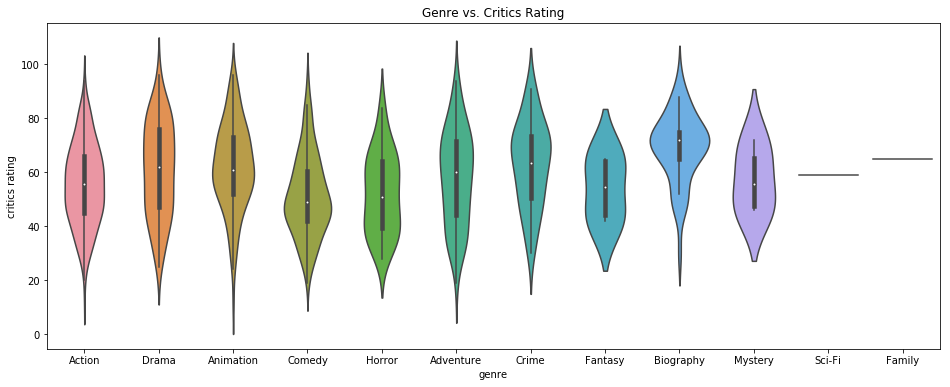

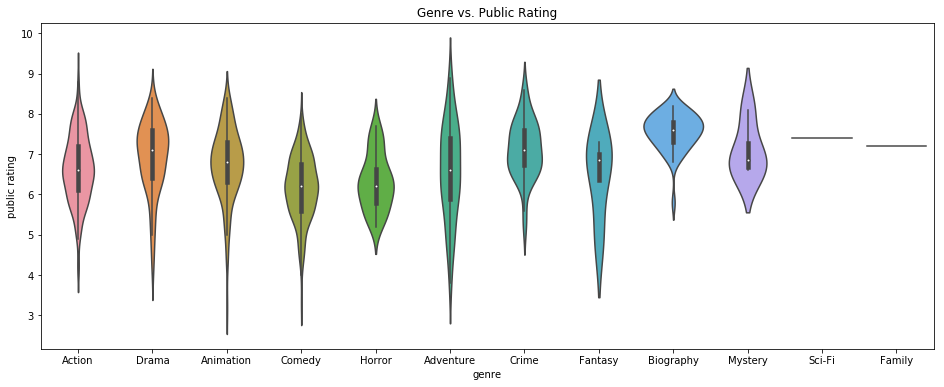

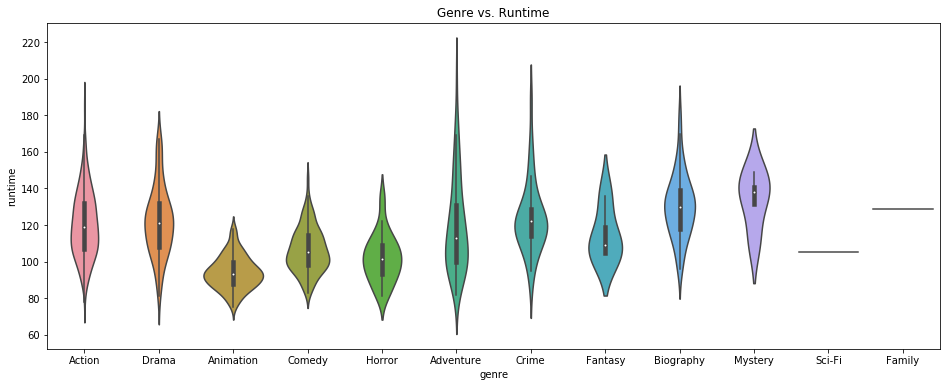

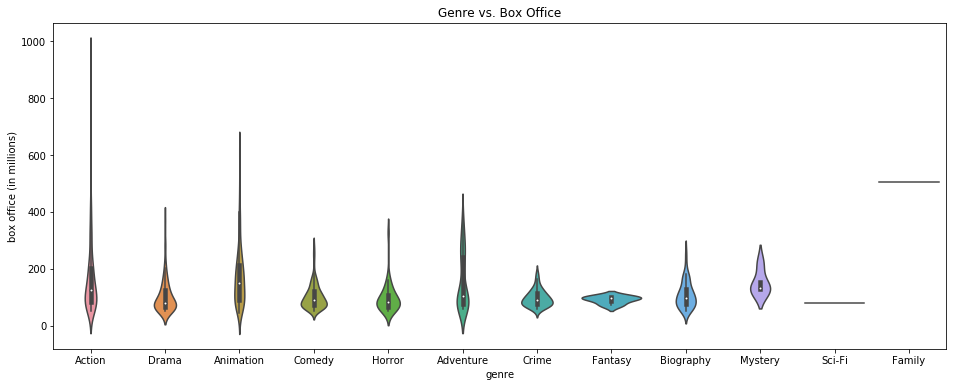

In [696]:
plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='genre', y='metacritic_rating', data=df)
fig.set(xlabel='genre', ylabel='critics rating', title = 'Genre vs. Critics Rating')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='genre', y='imdb_rating', data=df)
fig.set(xlabel='genre', ylabel='public rating', title = 'Genre vs. Public Rating')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='genre', y='runtime', data=df)
fig.set(xlabel='genre', ylabel='runtime', title = 'Genre vs. Runtime')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='genre', y='gross_millions', data=df)
fig.set(xlabel='genre', ylabel='box office (in millions)', title = 'Genre vs. Box Office')
plt.show()

In the following violin plots, we display the relationships between MPAA ratings and their critics ratings, public ratings, runtime, and box office gross.  We observe the following:
- Rated R films tend to be slightly more highly rated by critics.
- A lot of G rated films are rated around 60/100 among critics.
- G rated films tend to be slightly highly rated among public ratings, especially in comparison to critics ratings.  
- G and PG films tend to have lower runtimes, PG-13 and R films tend to have higher runtimes.
- PG-13 films tend to make the most at the box office.  R films tend to make under the $200 million mark. 

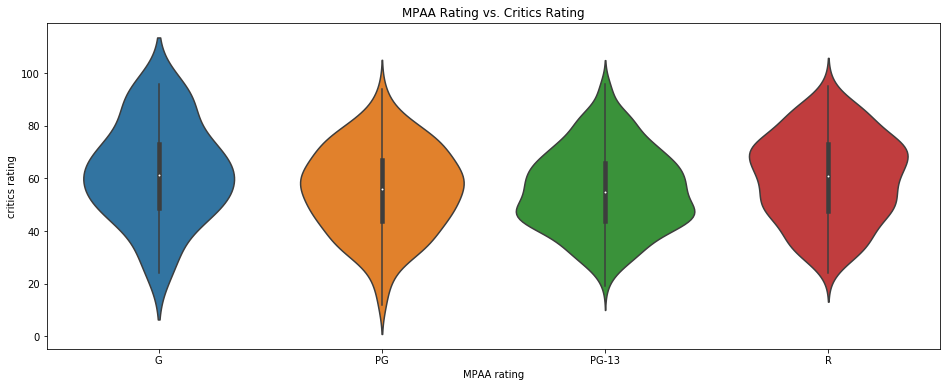

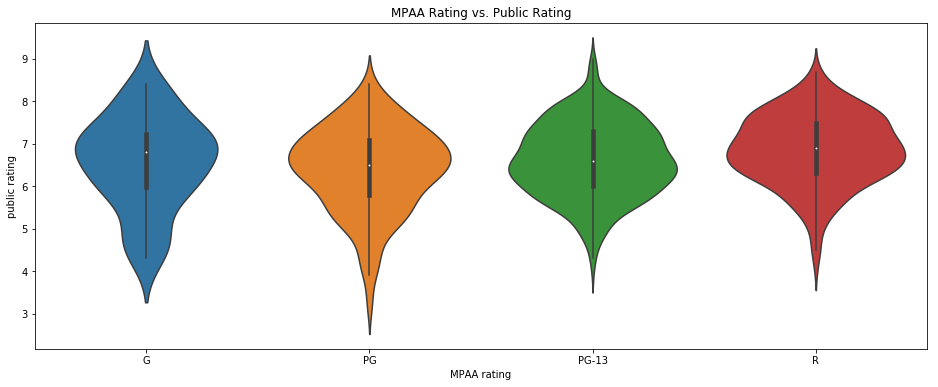

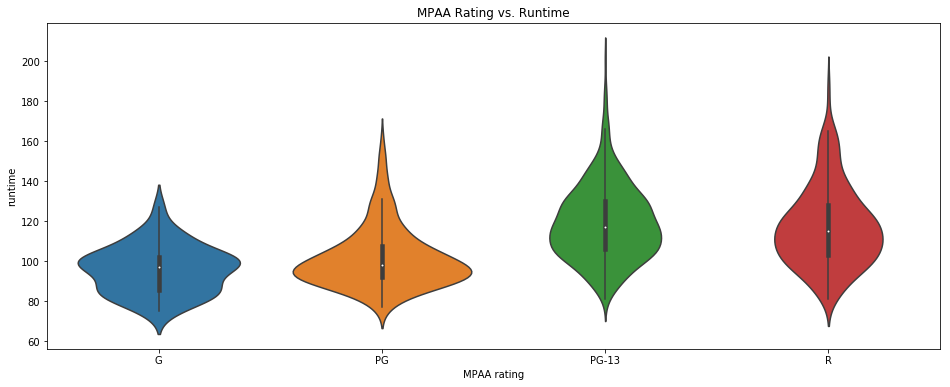

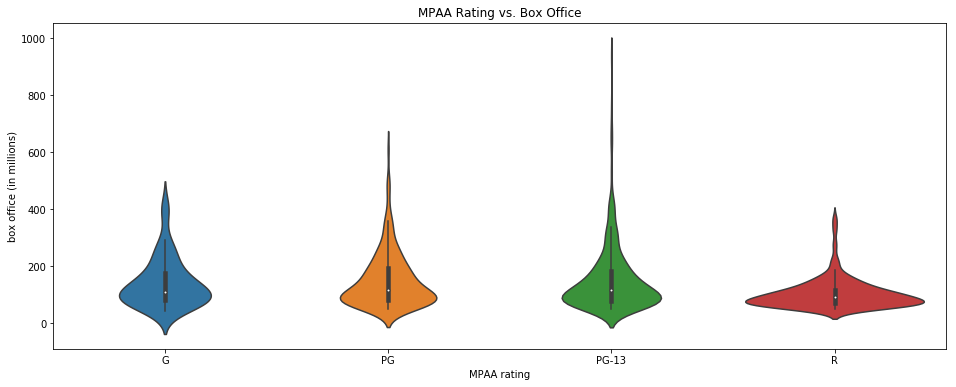

In [697]:
plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='mpaa_rating', y='metacritic_rating', data=df, order=['G', 'PG', 'PG-13', 'R'])
fig.set(xlabel='MPAA rating', ylabel='critics rating', title = 'MPAA Rating vs. Critics Rating')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='mpaa_rating', y='imdb_rating', data=df, order=['G', 'PG', 'PG-13', 'R'])
fig.set(xlabel='MPAA rating', ylabel='public rating', title = 'MPAA Rating vs. Public Rating')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='mpaa_rating', y='runtime', data=df, order=['G', 'PG', 'PG-13', 'R'])
fig.set(xlabel='MPAA rating', ylabel='runtime', title = 'MPAA Rating vs. Runtime')
plt.show()

plt.figure(figsize=(16, 6))
fig = sns.violinplot(x='mpaa_rating', y='gross_millions', data=df, order=['G', 'PG', 'PG-13', 'R'])
fig.set(xlabel='MPAA rating', ylabel='box office (in millions)', title = 'MPAA Rating vs. Box Office')
plt.show()

### HYPOTHESIS TESTING AND MACHINE LEARNING
In this next stage of the data life cycle, we will perform a modeling technique known as 'linear regression' to obtain a predictive model of our data that will allow us to predict values outside of what we have available in our data set.  More specifically, we will be focusing on Critics Ratings vs. Public Ratings in order to come up with a model to predict public reaction for films based on their reviews from critics. 

First, recall this plot where we were able to eyeball our dataset and try to manually find a potential relationship between Critics vs. Public Ratings.  

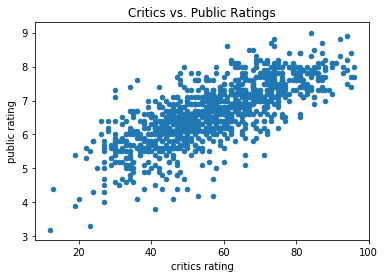

In [698]:
df.plot(x='metacritic_rating',y='imdb_rating',kind='scatter')
plt.xlabel('critics rating')
plt.ylabel('public rating')
plt.title('Critics vs. Public Ratings')
plt.show()

Divide the data into independent and dependent variables, so that critics ratings will be stored as x values (independent variables) and public ratings will be stored as y values (dependent variables). 

In [699]:
X = df['metacritic_rating'].values.reshape(-1,1)
y = df['imdb_rating'].values.reshape(-1,1)

Next, we split 80% of the data for the "training set" and the remaining 20% for the "testing set." 
Then, we create an instance of the LinearRegression class and call the fit() function using our training sets as parameters in order to create our model. 
From this, we are given the coefficient and slope of our model, which is a line that best fits the data.  So, our model can be described as:
**y = 0.04154833x + 4.25573127**

In [700]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
model = regressor.fit(X_train, y_train) #train the algorithm

# The intercept
print("Intercept: {}".format(regressor.intercept_))
# The slope
print("Slope: {}".format(regressor.coef_))

Intercept: [4.25573127]
Slope: [[0.04154833]]


Now that we have trained our algorithm, we must make predictions using our testing sets.  We do this by calling the predict() function.  We then store the actual values (from y_test) and the predicted values (from calling the predict() function) in a DataFrame.  

In [701]:
y_prediction = regressor.predict(X_test)
actual_predicted = pd.DataFrame({'actual': y_test.flatten(), 'predicted': y_prediction.flatten()})

We then make a scatter plot of the points in the DataFrame along with a y=x line.  As you can see, the actual and predicted values fit pretty closely along this y=x line, implying that our model is a fairly good one.  

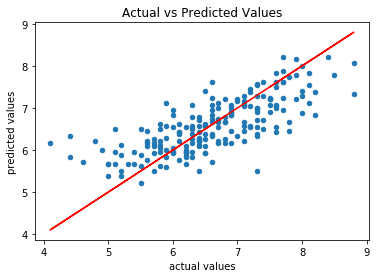

In [702]:
actual_predicted.plot(x='actual',y='predicted',kind='scatter')
plt.plot(y_test, y_test, color="Red")
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('Actual vs Predicted Values')
plt.show()

We then make a scatter plot with our actual data along with the predictive model/line.  

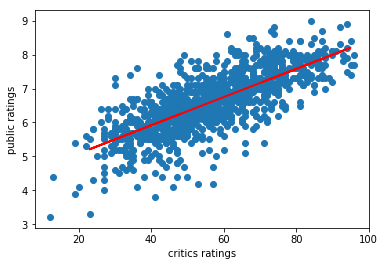

In [703]:
plt.scatter(X, y)
plt.plot(X_test, y_prediction, color='red', linewidth=2)
plt.xlabel('critics ratings')
plt.ylabel('public ratings')
plt.show()

We then compute the R-squared value, which on a scale of 0 to 1, comes out to be 0.5579173949083827, indicating that our model is fairly good. 

In [704]:
# R-squared value
print("R-squared value (scale of 0 to 1): {}".format(model.score(X_test, y_test)))

R-squared value (scale of 0 to 1): 0.5579173949083827


### CONCLUSIONS 
Based on our observations in this project, we can infer a number of things: 
- Overall public ratings and critics ratings are quite close and in general agreement with each other. 
- Critics rate films more harshly than the public.
- Action and PG-13 movies dominate the box office. 
- Runtimes are generally between 80-150 minutes.  Films inside this range generally make the most money.
- Animation and Biography films tend to be highly rated by critics, whereas Comedy films tend to be rated lower by critics. 
- Action and Comedy films are where critics and public ratings tend to have the most disparity. 
- R rated films generally do not make more than $200 million at the box office.

Overall, this data and analysis presents an interesting look into trends behind the film industry over the past two decades and finding out what makes a successful film in the U.S..

Thank you for reading!